# Italy Covid 19 vaccination data analysis and visualization

**Author**: Fabio Sona<br>
**Date**: 02 March 2021<br>
**Content**<br>
Data visualization and analyisis of Italy Covid 19 vaccination status based on opendata repository managed, on github, by "**Italian Government**" 

---


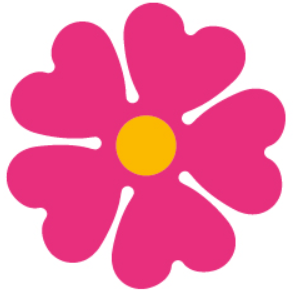

## Libraries Import 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
import seaborn as sns
import datetime
from datetime import date
import numpy as np
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import scipy.special as sps 
import warnings 

## Data upload and cleaning

In [33]:
#%%
# Read region based data  from Italian Government repository 
dfVana=pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/anagrafica-vaccini-summary-latest.csv")
dfVdel=pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/consegne-vaccini-latest.csv",index_col=3, parse_dates=True)
dfVadm_loc=pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/punti-somministrazione-latest.csv")
dfVloc_type=pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/punti-somministrazione-tipologia.csv")
dfVadm=pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/somministrazioni-vaccini-latest.csv",index_col=0, parse_dates=True)
dfVadm_sum=pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/somministrazioni-vaccini-summary-latest.csv")
dfVsum=pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/vaccini-summary-latest.csv")

In [34]:
dfVadm.head(21)

,fornitore,area,fascia_anagrafica,sesso_maschile,sesso_femminile,categoria_operatori_sanitari_sociosanitari,categoria_personale_non_sanitario,categoria_ospiti_rsa,categoria_over80,categoria_forze_armate,categoria_personale_scolastico,prima_dose,seconda_dose,codice_NUTS1,codice_NUTS2,codice_regione_ISTAT,nome_area
data_somministrazione,,,,,,,,,,,,,,,,,
2020-12-27,Pfizer/BioNTech,ABR,20-29,1,0,1,0,0,0,0,0,1,0,ITF,ITF1,13,Abruzzo
2020-12-27,Pfizer/BioNTech,ABR,30-39,1,3,4,0,0,0,0,0,4,0,ITF,ITF1,13,Abruzzo
2020-12-27,Pfizer/BioNTech,ABR,40-49,1,6,7,0,0,0,0,0,7,0,ITF,ITF1,13,Abruzzo
2020-12-27,Pfizer/BioNTech,ABR,50-59,4,5,9,0,0,0,0,0,9,0,ITF,ITF1,13,Abruzzo
2020-12-27,Pfizer/BioNTech,ABR,60-69,10,4,13,1,0,0,0,0,14,0,ITF,ITF1,13,Abruzzo
2020-12-27,Pfizer/BioNTech,ABR,70-79,1,0,0,0,1,0,0,0,1,0,ITF,ITF1,13,Abruzzo
2020-12-27,Pfizer/BioNTech,ABR,80-89,1,0,0,0,1,0,0,0,1,0,ITF,ITF1,13,Abruzzo
2020-12-27,Pfizer/BioNTech,BAS,20-29,4,5,9,0,0,0,0,0,9,0,ITF,ITF5,17,Basilicata
2020-12-27,Pfizer/BioNTech,BAS,30-39,10,18,27,1,0,0,0,0,28,0,ITF,ITF5,17,Basilicata


## Doses administration summary and by age group 

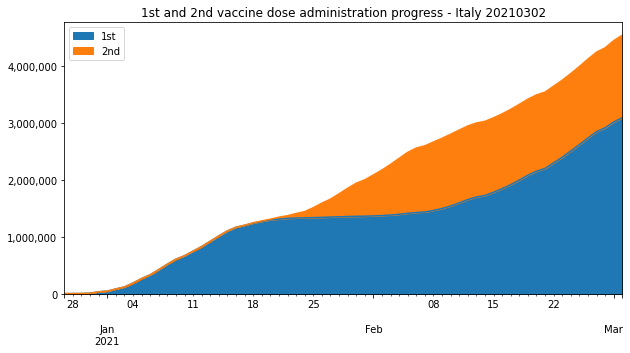

In [29]:

#Cumulative 1st 2nd dose Administered
dfAdm=dfVadm.copy()
dfAdm=dfAdm.sort_values('nome_area',ascending=True)
dfAdm['Week_Number'] = dfAdm.index.weekofyear
dfAdm['Year'] = dfAdm.index.year
dfAdm=dfAdm[['prima_dose','seconda_dose']]
dfAdm=dfAdm.groupby(['data_somministrazione']).sum() 
dfAdm=dfAdm.cumsum()
today=dfAdm.index[-1] #Get last date of relevant data 
d=today.strftime("%Y%m%d")
dfAdm=dfAdm.rename(columns={"prima_dose": "1st", "seconda_dose": "2nd"})

date_form = mdates.DateFormatter("%d-%m") #Format date into dd-mm format
fig, ax =plt.subplots(figsize=(10,5))
dfAdm.plot.area(ax=ax)


ax.set_xlabel('')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
#ax.xaxis.set_major_locator(mdates.MonthLocator())
#ax.xaxis.set_major_formatter(date_form)
#ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=SU))
#ax.xaxis.set_minor_formatter(ticker.NullFormatter())   
ax.legend()
plt.title('1st and 2nd vaccine dose administration progress - Italy '+d)
plt.savefig('V'+d+'_ItalyDosesPhaseProgress.png')

plt.show



In [44]:


print(dfAdm)

len=dfAdm.shape[0]
rate=(dfAdm.iat[65,1]+dfAdm.iat[65,0])/len
print(rate,rate*len)

                           1st      2nd
data_somministrazione                  
2020-12-27                7014        0
2020-12-28                7989        0
2020-12-29                8919        0
2020-12-30               13588        0
2020-12-31               38900        0
...                        ...      ...
2021-02-26             2738449  1383187
2021-02-27             2848644  1394423
2021-02-28             2916204  1402468
2021-03-01             3018122  1426349
2021-03-02             3093216  1447660

[66 rows x 2 columns]
68801.15151515152 4540876.0


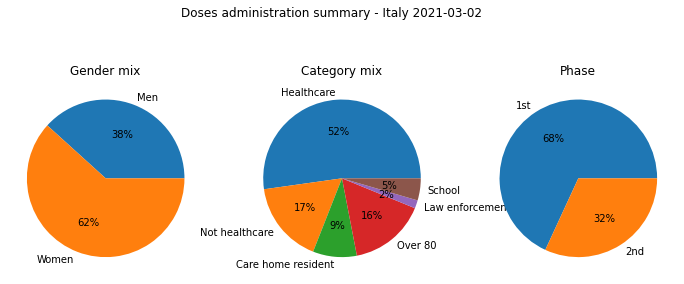

In [5]:
#Plot pie charts by Gender, Category and Phase
dfTemp=dfVana.copy()
dfTemp.loc['Column_Total']= dfTemp.sum(numeric_only=True, axis=0)
rows=dfTemp.shape[0]-1
d=dfVana.iat[0,12] #Get Date of update
#print(dfTemp)
#Set up picture frame
fig, axs = plt.subplots(1,3,figsize=(12,5))
warnings.filterwarnings("ignore") # specify to ignore warning messages

#Plot Gender mix
data=dfTemp.iloc[rows:,2:4]
labels = 'Men', 'Women'
axs[0].pie(data,labels=labels, autopct='%1.0f%%') #labeldistance=None,pctdistance=1.1,startangle=-15)
axs[0].set_title('Gender mix')

#Plot Cat mix
data=dfTemp.iloc[rows:,4:10]
labels = 'Healthcare', 'Not healthcare', 'Care home resident', 'Over 80','Law enforcement','School'
axs[1].pie(data,labels=labels, autopct='%1.0f%%') #labeldistance=None,pctdistance=1.1,startangle=-15)
axs[1].set_title('Category mix')

#Plot 1st, 2nd mix
data=dfTemp.iloc[rows:,10:12]
labels = '1st', '2nd'
axs[2].pie(data,labels=labels, autopct='%1.0f%%') #labeldistance=None,pctdistance=1.1,startangle=-15)
axs[2].set_title('Phase')

fig.suptitle('Doses administration summary - Italy '+d)
plt.savefig('V'+d+'_ItalyDosesSummary.png')
plt.show()


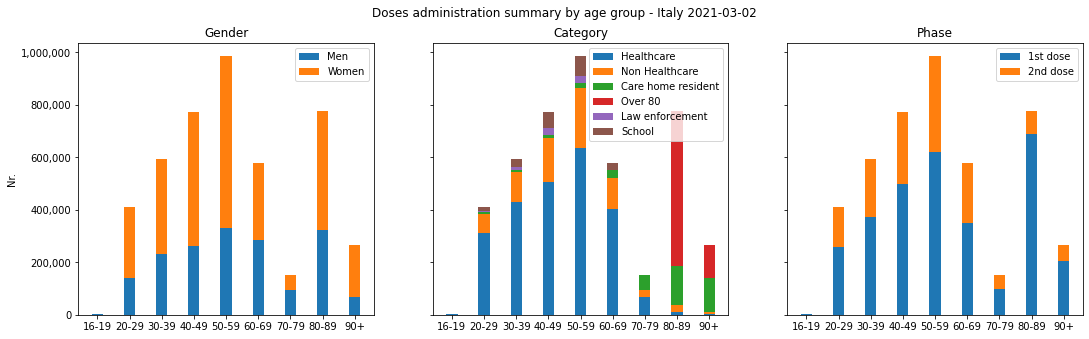

In [6]:
#Plot bar charts by Gender, Category and Phase and breakdown by age group

#Set up picture frame
fig, axs = plt.subplots(1,3,figsize=(18,5),sharey=True)
width = 0.35       # the width of the bars: can also be len(x) sequence
labels = dfVana['fascia_anagrafica']

#By Gender
men = dfVana['sesso_maschile']
women = dfVana['sesso_femminile']

axs[0].bar(labels, men, width,label='Men')
axs[0].bar(labels, women, width, bottom=men,label='Women')
axs[0].set_ylabel('Nr.')
axs[0].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
axs[0].set_title('Gender')
axs[0].legend()

#By Category
dfCat=dfVana.iloc[:,4:10]
ssn = dfVana['categoria_operatori_sanitari_sociosanitari']
non_san = dfVana['categoria_personale_non_sanitario']
rsa = dfVana['categoria_ospiti_rsa']
over80 = dfVana['categoria_over80']
ffaa = dfVana['categoria_forze_armate']
scuola = dfVana['categoria_personale_scolastico']

 
# Values of each group
bars1 = [12, 28, 1, 8, 22]
bars2 = [28, 7, 16, 4, 10]
bars3 = [25, 3, 23, 25, 17]
 
# Heights of bars1 + bars2
#bars1 = np.add(ssn).tolist()
bars2 = np.add(ssn,non_san).tolist()
bars3 = np.add(bars2,rsa).tolist()
bars4 = np.add(bars3,over80).tolist()
bars5 = np.add(bars4,ffaa).tolist()
bars6 = np.add(bars5,scuola).tolist()

axs[1].bar(labels, ssn, width,label='Healthcare')
axs[1].bar(labels, non_san, width, bottom=ssn,label='Non Healthcare')
axs[1].bar(labels, rsa, width, bottom=bars2,label='Care home resident')
axs[1].bar(labels, over80, width, bottom=bars3,label='Over 80')
axs[1].bar(labels, ffaa, width, bottom=bars4,label='Law enforcement')
axs[1].bar(labels, scuola, width, bottom=bars5,label='School')
#axs[1].set_ylabel('Nr.')
axs[1].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
axs[1].set_title('Category')
axs[1].legend()

#By Phase
first = dfVana['prima_dose']
second = dfVana['seconda_dose']

axs[2].bar(labels, first, width,label='1st dose')
axs[2].bar(labels,second, width, bottom=first, label='2nd dose')

#axs[2].set_ylabel('Nr.')
axs[2].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
axs[2].set_title('Phase')
axs[2].legend()
fig.suptitle('Doses administration summary by age group - Italy '+d)

plt.savefig('V'+d+'_ItalyVaccinationCategoriesAgeGroup.png')
plt.show()


## Doses delivery supplier breakdown summary and by region

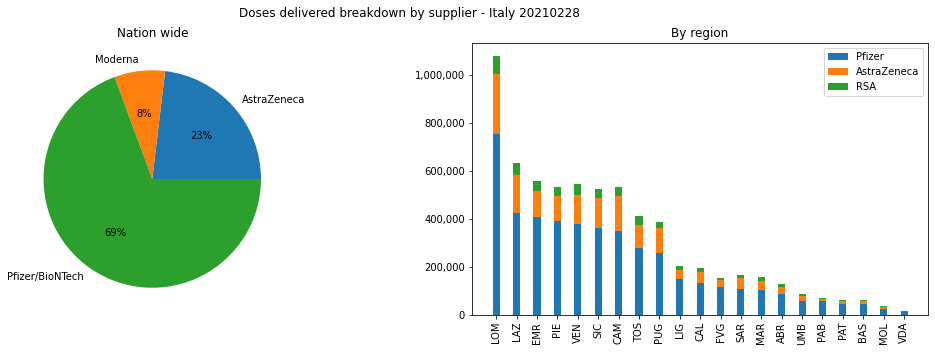

<function matplotlib.pyplot.show>

In [7]:
#Plot Vaccine supplier mix Italy and per region
today=dfVdel.index[-1] #Get last date of relevant data 
d=today.strftime("%Y%m%d")

fig, axs = plt.subplots(1,2,figsize=(18,5))
warnings.filterwarnings("ignore") # specify to ignore warning messages

#Mix Italy
dfTemp=dfVdel.copy()
dfTemp=dfTemp.groupby(['fornitore'])['numero_dosi'].sum()
#dfTemp.index
#dfTemp.head()
data=dfTemp
labels = dfTemp.index
axs[0].pie(data,labels=labels, autopct='%1.0f%%') #labeldistance=None,pctdistance=1.1,startangle=-15)
axs[0].set_title('Nation wide')

#Mix per region
width = 0.35
dfTemp=pd.pivot_table(dfVdel, values = 'numero_dosi',aggfunc=np.sum, index=['area'], columns = 'fornitore').reset_index()
dfTemp=dfTemp.sort_values(by=['Pfizer/BioNTech'],ascending=False)
pfz=dfTemp['Pfizer/BioNTech']
az=dfTemp['AstraZeneca']
mod=dfTemp['Moderna']
labels=dfTemp['area']
# Heights of bars1 + bars2

bars2 = np.add(pfz,az).tolist()

axs[1].bar(labels,pfz, width,label='Pfizer')
axs[1].bar(labels, az,width, bottom=pfz,label='AstraZeneca')
axs[1].bar(labels, mod, width, bottom=bars2,label='RSA')
axs[1].set_xticklabels(labels, rotation = 90)
#axs[1].set_ylabel('Nr.')
axs[1].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
axs[1].set_title('By region')
axs[1].legend()
fig.suptitle('Doses delivered breakdown by supplier - Italy '+d)

plt.savefig('V'+d+'_ItalyVaccinationDosesSupplier.png')
plt.show()

plt.show

## Doses administration progress by region

<function matplotlib.pyplot.show>

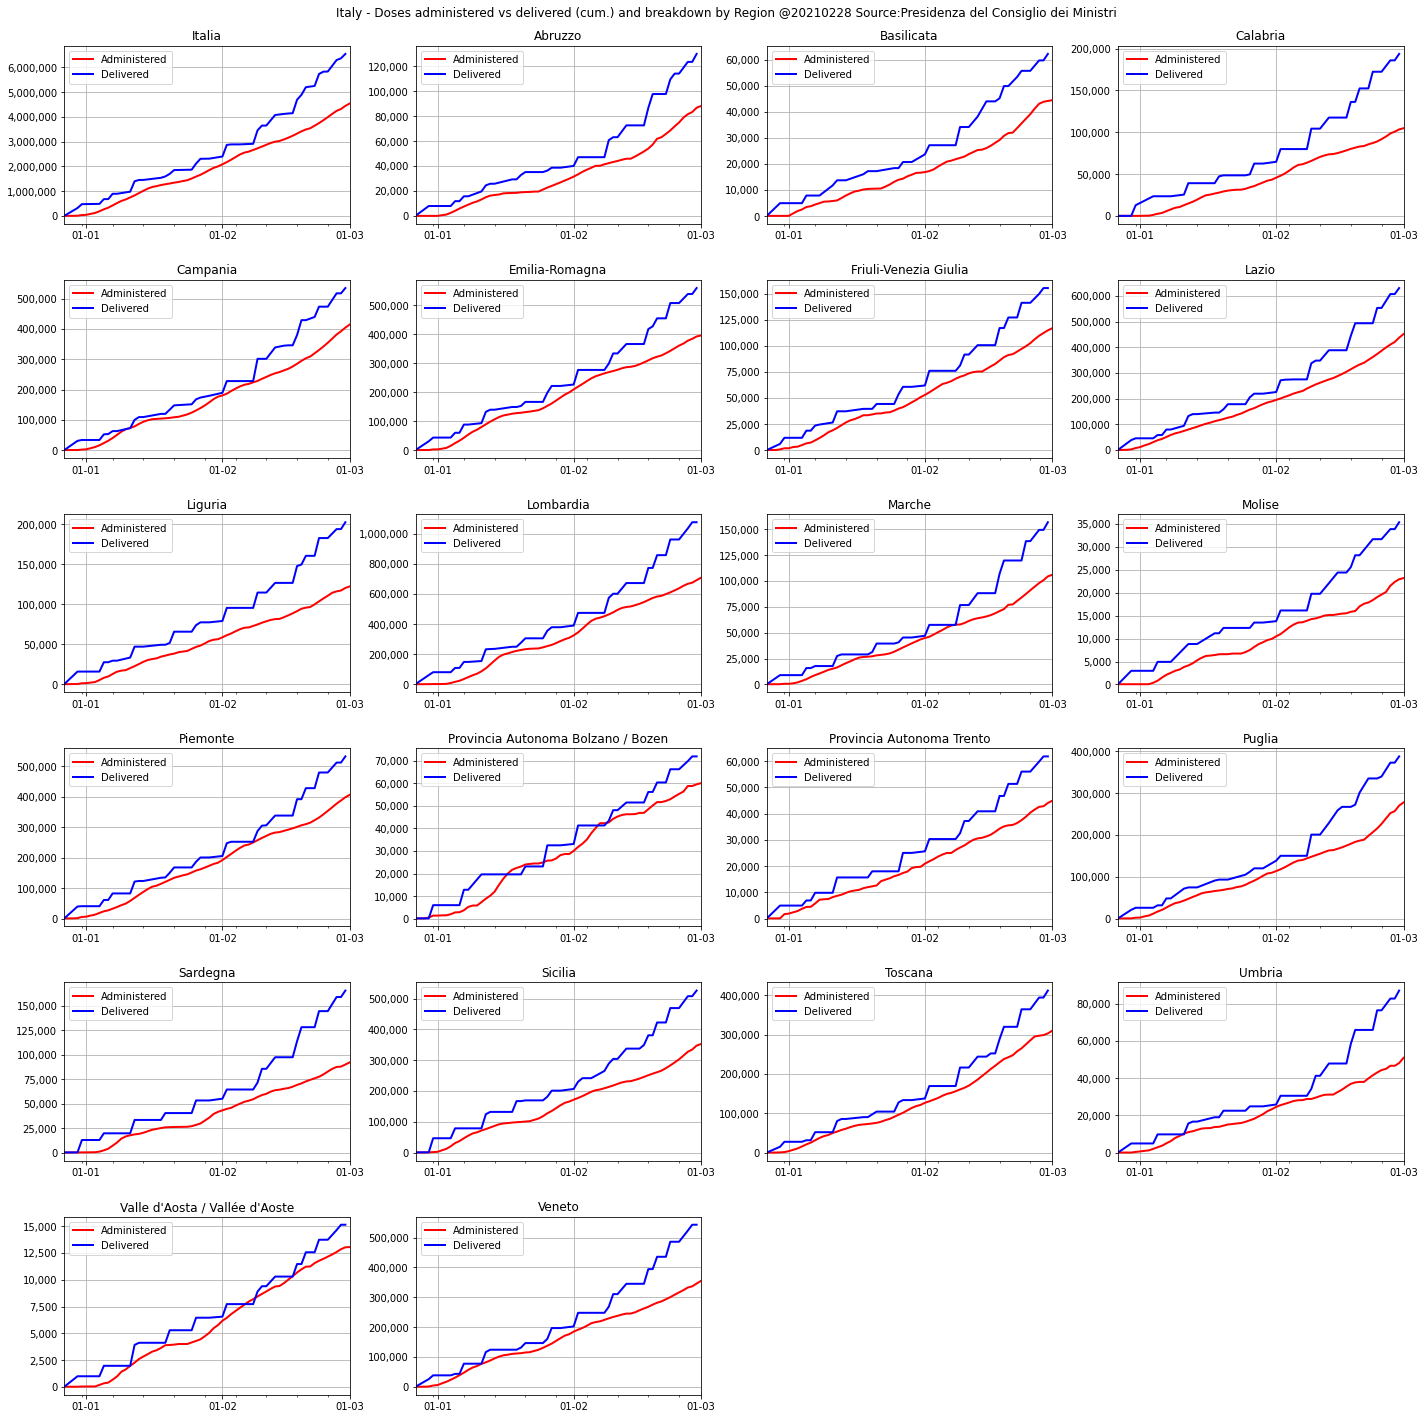

In [17]:
#Prepare data to plot administered doses vs. delivered on a daily basis
#Delivered
dfDel=dfVdel.copy()
dfDel=dfDel.sort_values('nome_area',ascending=True)
dfDel['Week_Number'] = dfDel.index.weekofyear
dfDel['Year'] = dfDel.index.year
dfDel=pd.pivot_table(dfDel, values = 'numero_dosi',index = ['data_consegna'],aggfunc=np.sum, columns = 'nome_area')#.reset_index()
dfDel=dfDel.cumsum().reset_index()
dfDel=dfDel.fillna(method='ffill')
dfDel.set_index('data_consegna',inplace=True)
dfDel["sum"] = dfDel.sum(axis=1)
#dfDel.head(100)

#Administered
dfAdm=dfVadm.copy()
dfAdm=dfAdm.sort_values('nome_area',ascending=True)
dfAdm['Week_Number'] = dfAdm.index.weekofyear
dfAdm['Year'] = dfAdm.index.year
dfAdm['tot_dosi']= dfAdm['sesso_maschile'] + dfAdm['sesso_femminile']
dfAdm=pd.pivot_table(dfAdm, values = 'tot_dosi',index = ['data_somministrazione'],aggfunc=np.sum, columns = 'nome_area')
dfAdm=dfAdm.cumsum().reset_index()
dfAdm=dfAdm.fillna(method='ffill')
dfAdm.set_index('data_somministrazione',inplace=True)
dfAdm["sum"] = dfAdm.sum(axis=1)
#dfAdm.head(100)


#Main loop
nrows=6 
ncols=4
fig, axes = plt.subplots(nrows, ncols,sharex=False,figsize=(20,20)) #
fig.tight_layout(pad=3.5)
date_form = mdates.DateFormatter("%d-%m") #Format date into dd-mm format
idx=0
for r in range(nrows):
  for c in range(ncols):
    if r==0 and c==0: #First box for Nationwide data 
        dfAdm[dfAdm.columns[21]].plot(kind='line', linestyle="-",lw=2,color='red',grid=True,rot=0,legend=False,label='Administered',ax=axes[r,c],sharex=False)
        dfDel[dfDel.columns[21]].plot(kind='line', linestyle="-",lw=2,color='blue',grid=True,rot=0,legend=False,label='Delivered',ax=axes[r,c],sharex=False)
        axes[r,c].set_title('Italia')
        axes[r,c].set_xlabel('')
        axes[r,c].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
        axes[r,c].xaxis.set_major_locator(mdates.MonthLocator())
        axes[r,c].xaxis.set_major_formatter(date_form)
        axes[r,c].xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=SU))
        axes[r,c].xaxis.set_minor_formatter(ticker.NullFormatter())   
        axes[r,c].legend()
        #idx=idx+1    
    
    elif  idx<=20 : #then plot regions individually
      
        dfAdm[dfAdm.columns[idx]].plot(kind='line', linestyle="-",lw=2,color='red',grid=True,rot=0,legend=False,label='Administered',ax=axes[r,c],sharex=False)
        dfDel[dfDel.columns[idx]].plot(kind='line', linestyle="-",lw=2,color='blue',grid=True,rot=0,legend=False,label='Delivered',ax=axes[r,c],sharex=False)
        axes[r,c].set_title(dfAdm.columns[idx])
        axes[r,c].set_xlabel('')
        axes[r,c].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
        axes[r,c].xaxis.set_major_locator(mdates.MonthLocator())
        axes[r,c].xaxis.set_major_formatter(date_form)
        axes[r,c].xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=SU))
        axes[r,c].xaxis.set_minor_formatter(ticker.NullFormatter())   
        axes[r,c].legend()
        idx=idx+1
    else:
      break
axes[nrows-1,ncols-1].set_visible(False)
axes[nrows-1,ncols-2].set_visible(False)

fig.suptitle('Italy - Doses administered vs delivered (cum.) and breakdown by Region @'+d+' Source:Presidenza del Consiglio dei Ministri',y=1.0, x=0.5) 
plt.savefig('V'+d+'_ItalyDosesStatusRegion.png')
plt.show

<function matplotlib.pyplot.show>

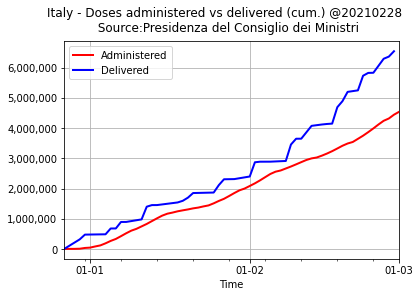

In [21]:
#Prepare data to plot administered doses vs. delivered on a daily basis
#Delivered
dfDel=dfVdel.copy()
dfDel=dfDel.sort_values('nome_area',ascending=True)
dfDel['Week_Number'] = dfDel.index.weekofyear
dfDel['Year'] = dfDel.index.year
dfDel=pd.pivot_table(dfDel, values = 'numero_dosi',index = ['data_consegna'],aggfunc=np.sum, columns = 'nome_area')#.reset_index()
dfDel=dfDel.cumsum().reset_index()
dfDel=dfDel.fillna(method='ffill')
dfDel.set_index('data_consegna',inplace=True)
dfDel["sum"] = dfDel.sum(axis=1)
#dfDel.head(100)

#Administered
dfAdm=dfVadm.copy()
dfAdm=dfAdm.sort_values('nome_area',ascending=True)
dfAdm['Week_Number'] = dfAdm.index.weekofyear
dfAdm['Year'] = dfAdm.index.year
dfAdm['tot_dosi']= dfAdm['sesso_maschile'] + dfAdm['sesso_femminile']
dfAdm=pd.pivot_table(dfAdm, values = 'tot_dosi',index = ['data_somministrazione'],aggfunc=np.sum, columns = 'nome_area')
dfAdm=dfAdm.cumsum().reset_index()
dfAdm=dfAdm.fillna(method='ffill')
dfAdm.set_index('data_somministrazione',inplace=True)
dfAdm["sum"] = dfAdm.sum(axis=1)
#dfAdm.head(100)


fig, ax = plt.subplots(figsize=(6,4)) #

date_form = mdates.DateFormatter("%d-%m") #Format date into dd-mm format
dfAdm[dfAdm.columns[21]].plot(kind='line', linestyle="-",lw=2,color='red',grid=True,rot=0,legend=False,label='Administered',ax=ax,sharex=False)
dfDel[dfDel.columns[21]].plot(kind='line', linestyle="-",lw=2,color='blue',grid=True,rot=0,legend=False,label='Delivered',ax=ax,sharex=False)
#ax.set_title('Italia')
ax.set_xlabel('Time')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=SU))
ax.xaxis.set_minor_formatter(ticker.NullFormatter())   
ax.legend()

fig.suptitle('Italy - Doses administered vs delivered (cum.) @'+d+' \n Source:Presidenza del Consiglio dei Ministri',y=1.0, x=0.5) 
plt.savefig('V'+d+'_ItalyDosesStatus.png')
plt.show

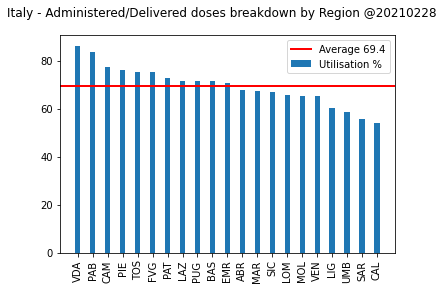

In [14]:
#Utilisation
dfTemp=dfVsum.copy()
width = 0.35
dfTemp=dfTemp.sort_values(by=['percentuale_somministrazione'],ascending=False)
labels=dfTemp['area']
data=dfTemp['percentuale_somministrazione']
ave_prc=dfTemp['dosi_somministrate'].sum()/dfTemp['dosi_consegnate'].sum()*100

fig,ax = plt.subplots(figsize=(6,4))

ax.bar(labels,data, width,label='Utilisation %')
ax.axhline(y=ave_prc, color='red',lw=2, linestyle='-', label='Average ' + str(int(ave_prc*10)/10))
ax.set_xticklabels(labels, rotation = 90) 
plt.legend()
fig.suptitle('Italy - Administered/Delivered doses breakdown by Region @'+d) #+" Source:Presidenza del Consiglio dei Ministri",y=1.0, x=0.5) 
plt.savefig('V'+d+'_ItalyDosesUtilisationRegion.png')
plt.show()


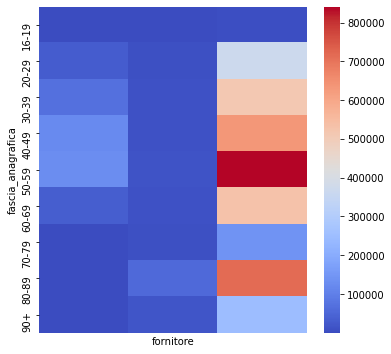

fornitore,AstraZeneca,Moderna,Pfizer/BioNTech
fascia_anagrafica,,,
16-19,164,225,4183
20-29,32702,7344,369003
30-39,69328,10372,515102
40-49,122609,13084,637376
50-59,129916,15705,841103
60-69,34906,12231,531473
70-79,26,8217,143540
80-89,48,56152,719297
90+,16,17907,248847


In [10]:
#Pivot Fasce anagrafiche fornitore vaccin
dfAdm=dfVadm.copy()
dfAdm['tot_dosi']= dfAdm['sesso_maschile'] + dfAdm['sesso_femminile']
dfAdm=pd.pivot_table(dfAdm, values = 'tot_dosi',index = ['fascia_anagrafica'],aggfunc=np.sum, columns = 'fornitore')


title_txt1=('Covid19 Cases/100K inhab. per geography \n @'+d+' (data source: Protezione Civile)')

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(dfAdm,xticklabels=False,cmap="coolwarm",ax=ax)
#axes[0].set(title=title_txt1,xlabel="Time")
#plt.savefig(d+'ItalyDashboardHeatmap.png')
plt.show()

dfAdm.head(100)